In [1]:
import numpy as np
import glob
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:
PATH = '../lab1/ustawy/'
file_names = sorted(glob.glob(PATH + "*"))
file_names[:5]

['../lab1/ustawy/1993_599.txt',
 '../lab1/ustawy/1993_602.txt',
 '../lab1/ustawy/1993_645.txt',
 '../lab1/ustawy/1993_646.txt',
 '../lab1/ustawy/1994_150.txt']

In [3]:
law_acts =[]
for file_name in file_names:
    with open(file_name, "r", encoding="utf-8") as f:
        law_acts.append(f.read())

# Zadanie 4

Wybranie 50 największych projektów ustaw

In [4]:
law_acts.sort(key=(lambda a: -len(a)))
law_acts = law_acts[:50]

# Zadanie 5

Wyznaczenie wyrażeń, których wszystkie słowa zaczynają się z dużej litery i nie znajdują się na początku zdania. Na początek wykorzystuję tagger do podziału dokumentów na tokeny składające się z pary (lemat, oryginalne słowo).

In [5]:
%%time
tokens_per_act = []

for law_act in law_acts:
    response_lines = requests.post('http://localhost:9200', law_act.encode('utf-8')).content.decode('utf-8').split('\n')
    tokens = []
    word = ''
    for line in response_lines:
        line_words = line.split('\t')
        if line_words[0] != '':
            word = line_words[0]
        elif len(line_words) >= 2:
            tokens.append((line_words[1].strip(), word))
    tokens_per_act.append(tokens)

CPU times: user 4.04 s, sys: 437 ms, total: 4.47 s
Wall time: 28min 38s


In [6]:
print(tokens_per_act[0][:5])
print(tokens_per_act[1][:5])

[('dziennik', 'Dz'), ('.', '.'), ('ustawa', 'U'), ('.', '.'), ('z', 'z')]
[('dziennik', 'Dz'), ('.', '.'), ('ustawa', 'U'), ('.', '.'), ('z', 'z')]


Następnie dzielę dokumenty na zdania. Podziału na zdania dokonuje na podstawie wystąpień znaku '.'. Zapisuję listy tokenów występujących w każdym zdaniu.

In [7]:
%%time
tokens_per_sentence = []
for tokens in tokens_per_act:
    sentence_tokens = []
    for token in tokens:
        if token[0] != '.':
            sentence_tokens.append(token)
        elif len(sentence_tokens) > 0:
                tokens_per_sentence.append(sentence_tokens)
                sentence_tokens = []

CPU times: user 662 ms, sys: 31.7 ms, total: 694 ms
Wall time: 691 ms


In [8]:
tokens_per_sentence[:5]

[[('dziennik', 'Dz')],
 [('ustawa', 'U')],
 [('z', 'z'), ('1998', '1998'), ('rok', 'r')],
 [('numer', 'Nr'), ('106', '106'), (',', ','), ('pozycja', 'poz')],
 [('668', '668'),
  ('ustawa', 'USTAWA'),
  ('z', 'z'),
  ('dzień', 'dnia'),
  ('24', '24'),
  ('lipiec', 'lipca'),
  ('1998', '1998'),
  ('rok', 'r')]]

Następinie wyznaczam entries (szukane wyrażenia) w każdym ze zdań osobno.

In [9]:
%%time
entries_per_sentence = []
for sentence_tokens in tokens_per_sentence:
    sentence_entries = []
    entry = []
    for token in sentence_tokens[1:]:
        if token[1][0].isupper():
            lemma = token[0][0].upper() + token[0][1:]
            entry.append(lemma)
        elif len(entry) > 0:
            sentence_entries.append(entry)
            entry=[]
    entries_per_sentence.append(sentence_entries)

CPU times: user 713 ms, sys: 11.3 ms, total: 724 ms
Wall time: 722 ms


In [10]:
entries_per_sentence[:10]

[[], [], [], [], [['Ustawa']], [], [], [], [], []]

Spłaszczam listę wyrażeń.

In [11]:
entries = sum(entries_per_sentence, [])
entries = [' '.join(entry_words) for entry_words in entries]
entries[:5]

['Ustawa',
 'Minister',
 'Minister Sprawa Wewnętrzny',
 'Minister',
 'Minister Sprawa Wewnętrzny']

# Zadanie 6

Obliczenie listy częstotliwości występowania znalezionych wyrażeń i wyświetlenie 50 najczęściej występujących

In [12]:
%%time
entries_counter = {}
for entry in entries:
    entries_counter[entry] = entries_counter.get(entry, 0) + 1

CPU times: user 11.2 ms, sys: 0 ns, total: 11.2 ms
Wall time: 11 ms


In [13]:
top_entries = sorted(list(entries_counter.items()), key=(lambda x: (-x[1], x[0])))[:50]
for e in top_entries:
    print(f'\033[1m{e[0]}\033[0m ({e[1]})')

Numer (3956)
Rzeczpospolita Polski (613)
Kodeks (517)
Policja (397)
Skarb Państwo (349)
Prawo (330)
Kasa Chory (284)
Minister (276)
Straż Graniczny (268)
Unia Europejski (260)
Rada Minister (255)
Z (231)
Państwowy Straż Pożarny (218)
Times (206)
Zakład (196)
Zmiana (190)
Rada (176)
Fundusz (164)
Sprawiedliwość (164)
Azot (162)
Państwowy Komisja Wyborczy (161)
Rozdział (151)
TIR (151)
Urząd Patentowy (151)
Pozostały (146)
Minister Sprawiedliwość (144)
Prezes Urząd (144)
Tkanina (141)
Minister Obrona Narodowy (139)
Znak (138)
I (132)
Obrona Narodowy (124)
Urząd Ochrona Państwo (118)
Finanse (116)
Prezes Rada Minister (115)
EFTA (114)
Nawóz (111)
P2O5 (110)
Wolny Handel (105)
CZ (104)
WSP (104)
Minister Finanse (101)
Przepis (101)
II (98)
Biuro (97)
Komisja (97)
Europejski Obszar Gospodarczy (95)
Europejski Porozumienie (95)
Maszyna (94)
Ordynacja (94)


# Zadanie 7

Znalezienie named entities za pomocą linera udostępnianego przez Clarin przy użyciu szczegółowych kategorii

In [14]:
clarin_url = "http://ws.clarin-pl.eu/nlprest2/base/process"

In [15]:
def prepare_json(text):
    return {
        'lpmn': 'any2txt|wcrft2|liner2({"model":"n82"})',
        'text': text, 
        'user': "moj@adres.mail"
    }

In [16]:
def extract_entities_from_response(beautified_response):
    lexemes_and_annotations = beautified_response.findAll(['lex', 'ann'])

    entities = []

    current_entity, current_entity_class, current_entity_value = [], None, None
    for lexeme_or_annotation in lexemes_and_annotations:
        if lexeme_or_annotation.name == 'lex':
            lexeme = lexeme_or_annotation
            lexeme_value = str(lexeme.find('base').next_sibling)
            continue
        
        annotation = lexeme_or_annotation
        annotation_value = int(annotation.text)
        # ommit annotations with value of 0
        if annotation_value == 0:
            continue
        full_class = annotation['chan']
        # extend entity if it did not change
        if full_class == current_entity_class and annotation_value == current_entity_value:
            current_entity.append(lexeme_value)
            continue
        # save entity if new one started and if its not None
        if current_entity_class is not None:
            entity = ' '.join(current_entity)
            coarse_class = '_'.join(current_entity_class.split('_')[:2])
            entities.append((entity, current_entity_class, coarse_class))
        # start new entity
        current_entity, current_entity_class, current_entity_value = [lexeme_value], full_class, annotation_value

    # save last entity if its not None
    if current_entity_class is not None:
        entity = ' '.join(current_entity)
        coarse_class = '_'.join(current_entity_class.split('_')[:2])
        entities.append((entity, current_entity_class, coarse_class))   
    
    return entities

In [17]:
%%time
entities_per_act = []

for law_act in law_acts:
    response = requests.post(clarin_url, json=prepare_json(law_act)).content
    beautified_response = BeautifulSoup(response)
    entities_per_act.append(extract_entities_from_response(beautified_response))
    print('.', end='')

..................................................CPU times: user 6min 17s, sys: 2.85 s, total: 6min 20s
Wall time: 3h 40min 51s


In [19]:
entities = sum(entities_per_act, [])

In [20]:
entities[:5]

[('Dzieje_(Apostolskie) . u . Dzieje_(Apostolskie) . u .',
  'nam_pro_media_periodic',
  'nam_pro'),
 ('fundusz praca', 'nam_org_institution', 'nam_org'),
 ('fundusz gwarantowany świadczenie pracowniczy',
  'nam_org_organization',
  'nam_org'),
 ('ordynacja podatkowy', 'nam_pro_title_document', 'nam_pro'),
 ('Dzieje_(Apostolskie) . u .', 'nam_pro_media_periodic', 'nam_pro')]

# Zadanie 8

Wyświetlenie histogramu znalezionych entities głównych kategorii

In [21]:
coarse_classes_counter = {}
for entity in entities:
    coarse_classes_counter[entity[2]] = coarse_classes_counter.get(entity[2], 0) + 1

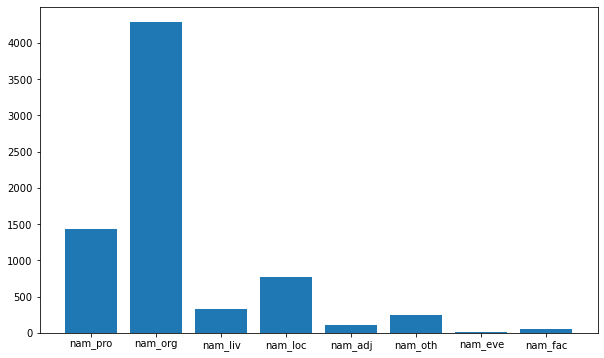

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(coarse_classes_counter.keys(), coarse_classes_counter.values())
plt.show()

# Zadanie 9

Wyświetlenie 10 najczęściej występujących nazw własnych dla każdej z głównych kategorii

In [23]:
coarse_classes_entities = {}
for entity in entities:
    coarse_classes_entities[entity[2]] = coarse_classes_entities.get(entity[2], []) + [entity[0]]
for coarse_class, entities_list in coarse_classes_entities.items():
    print(f'\033[1m{coarse_class}:\033[0m')
    entities_counter = {}
    for entity in entities_list:
        entities_counter[entity] = entities_counter.get(entity, 0) + 1
    top_entities = sorted(list(entities_counter.items()), key=(lambda x: (-x[1], x[0])))[:10]
    for e in top_entities:
        print(' ', e[0], f'({e[1]})')

nam_pro:
  Dzieje_(Apostolskie) . u . (463)
  dziennik . u . (66)
  sprawa (48)
  wewnętrzny (48)
  Dzieje_(Apostolskie) . u . Dzieje_(Apostolskie) . u . (33)
  ordynacja podatkowy (29)
  monitor Polska (23)
  konwencja (18)
  natura 2000 (14)
  kodeks postępowanie cywilny (13)
nam_org:
  unia europejski (184)
  skarb państwo (146)
  urząd ochrona państwo (109)
  prezes rad minister (90)
  EFTA (87)
  europejski porozumienie o Wolny handel (85)
  prezes urząd (81)
  minister finanse (80)
  rada minister (65)
  minister obrona narodowy (51)
nam_liv:
  kasa chora (66)
  gospodarka (21)
  żywnościowy (15)
  Art (9)
  kasa chora kasa chora (8)
  azot (7)
  główny inspektor farmaceutyczny (6)
  główny lekarz weterynaria (6)
  kasa (6)
  miedź (6)
nam_loc:
  rzeczpospolita polski (354)
  polski (57)
  rzeczpospolita (57)
  rzeczpospolita Polska (43)
  rzeczpospolita polski rzeczpospolita polski (30)
  Polska (23)
  nawóz (19)
  warszawa (18)
  Londyn (6)
  rzeczpospolita polski rzeczpospolit

# Zadanie 10

Wyświetlenie 50 najczęściej występujących nazw własnych

In [24]:
entities_counter = {}
for entity in entities:
    key = (entity[0], entity[1])
    entities_counter[key] = entities_counter.get(key, 0) + 1
top_entities = sorted(list(entities_counter.items()), key=(lambda x: (-x[1], x[0])))[:50]
for e in top_entities:
    print(f'\033[1m{e[0][0]}\033[0m {e[0][1]} ({e[1]})')

Dzieje_(Apostolskie) . u . nam_pro_media_periodic (463)
rzeczpospolita polski nam_loc_gpe_country (354)
unia europejski nam_org_organization (183)
skarb państwo nam_org_institution (146)
urząd ochrona państwo nam_org_institution (109)
złoty nam_oth_currency (104)
prezes rad minister nam_org_institution (90)
EFTA nam_org_organization (87)
europejski porozumienie o Wolny handel nam_org_company (85)
euro nam_oth_currency (81)
prezes urząd nam_org_institution (81)
minister finanse nam_org_institution (80)
dziennik . u . nam_pro_media_periodic (66)
kasa chora nam_liv_person (66)
rada minister nam_org_institution (65)
polski nam_adj_country (64)
polski nam_loc_gpe_country (57)
rzeczpospolita nam_loc_gpe_country (57)
minister obrona narodowy nam_org_institution (51)
minister skarb państwo nam_org_institution (49)
minister zdrowie i opieka społeczny nam_org_institution (49)
sprawa nam_pro_title (48)
wewnętrzny nam_org_institution (48)
wewnętrzny nam_pro_title (48)
rzeczpospolita Polska nam_loc

# Zadanie 11

1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

Identyfikacja nazw własnych przy pomocy zliczania wyrażeń z dużej litery dała średnie wyniki. Najpopularniejszą znalezioną nazwą własną było słowo numer, ze względu na częstość występowania skrótu Nr z dużej litery w tekstach ustaw. Wiele kolejnych znalezionych nazw własnych jest jednak w porządku np. Rzeczpospolita Polska, Skarb Państwa, Kasa Chorych itp. Około połowa znalezionych nazw to rzeczywiście konkretne i pełne nazwy własne, część została ucięta (np. Prawo,  Zakład, Rada itp.), co prawdopodobnie spowodowane było sposobem wykrywania zdań. Wykorzystanie dedykowanego narzędzia (NER) pozwoliło uzyskać znacząco lepsze efekty. Zdecydowania większość znalezionych nazw własnych jest poprawna (Rzeczpospolita Polska, Unia Europejska, prezes rady ministrów itp.). Zdarzają się pojedyncze błędy intepretacji skrótów (np. najczęściej występujące Dzieje_(Apostolskie).u., będące misinterpretacją Dziennika Ustaw) oraz pojedyncze niepełne nazwy własne (np. i administracja, wewnętrzny). Ogólnie NER poradził sobie lepiej od wcześniejszej metody, ale wykrywanie na podstawie występowania dużych liter też daje niezłe wyniki.

2. What are the drawbacks of the method based on capital letters?

- Trudność w wykryciu początku i końca zdania
- Częste wykrycia tylko fragmentów nazw własnych
- Brak wykrywania nazw własnych nie zaczynających się z dużej litery
- Wystarczy jedna mała litera w środku wyrażenia (np. 'i'), żeby uniemożliwić wykrycie pełnej nazwy (np. Wydział Informatyki, Elektroniki i Telekomunikacji)

3. What are the drawbacks of the method based on NER?

- Zdarzające się misinterpretacje skrótów
- Bardzo długi czas przetwarzania tekstów wejściowych
- Dziwny format danych zwrotnych (konieczność niewygodnego parsingu, zwłaszcza problemy gdy konkretne słowo zostaje przyporządkowane do więcej niż jednej nazwy własnej, ponadto numerki w annotacjach nie są unikatowe dla kategorii, więc nie da się łatwo pogrupować po kluczu złożonym z kategorii i numerku)

4. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

Najgorsze znalezione wyrażenia występują dla kategorii głównej nam_pro. Są kiepskie głównie przez występowanie źle zinterpretowanych skrótów (Dzieje_(Apostolskie) . u ., Dzieje_(Apostolskie) . u . Dzieje_(Apostolskie) . u .) oraz występowanie fragmentów nazw własnych (sprawa, wewnętrzny).
Najlepsze według mnie wyniki występują dla kategorii głównej nam_org. Wszystkie znalezione tam nazwy własne są poprawne oraz wszystkie są dobrze zaklasyfikowane - są to nazwy organizacji czy instytucji. Nawet znalazła się tam EFTA, czyli skrót reprezentujący Europejskie Stowarzyszenie Wolnego Handlu.

5. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that would be able to group such names together?

NER nie radzi sobie najlepiej z grupowaniem nazw własnych oznaczających to samo. Przykładowo dla kategorii nam_loc znaleziono rzeczpospolita polski (354), polski (57), rzeczpospolita (57), rzeczpospolita Polska (43), rzeczpospolita polski rzeczpospolita polski (30), Polska (23), a dla kategorii nam_adj polski, polski polski polski, polski polski. Żeby pogrupować nazwy własne oznaczające to samo możnaby wykorzystać np. embeding word2vec i sprawdzić, czy występują wyrażenia z tym samym embedingiem. Ewentualnie możnaby próbować wrzucić znalezione wyrażenia w wordnet i badać czy niektóre występują w tych samych synsetach.

6. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

- Badanie popularności firm na podstawie wystąpień ich nazw w tweetach
- Znajdywanie najpopularniejszych miejsc na wakacje na podstawie wystąpień ich nazw w tweetach z okresu letniego
- Znajdywanie instytucji wymagających reform ze względu na ich zbyt częste występowanie w ustawach
